# **Lab 1**
### Modelling and computation in hazard assessment
### 26-27 Februrary 2024


In Lab 1, we introduce fundamental data analysis and modelling concepts that will be demostrated in the lectures of the Computation and Modelling in Hazard Assessment training.

*   In the first section, we will set the environment and show basic operations

*   Then we'll load a dataset with in vitro genotoxocity data and explore it by creating some illustrative visualisations

*   Finally, we'll develop our first neural network model to model genotoxicity using a classification model

Note: This training is using a public computing platform and hence all data are not proprietary, not confidential and not subject to IPR restrictions. Still, the dataset has not been openly shared as this would require the inclusion of the relevant terms and conditions of the applicable licences. Be aware with using confidential data in public computing platforms and do not share this datase further.

## Environment setup

Firstly, lets' install packages that are needed later in the tutorial and that are not natively available in google colab.

In [1]:
# install the necessary packages that are not preinstalled in google colab
!pip install rdkit
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 48.8 MB/s eta 0:00:00


In [2]:
# import libraries
import numpy as np
import pandas as pd
import requests
from pathlib import Path
import time
from tqdm.notebook import tqdm
from rdkit import Chem                        #cheminformatics
from rdkit.Chem import AllChem                #cheminformatics
from rdkit.Chem import Draw                   #cheminformatics
from rdkit.Chem.Draw import rdMolDraw2D       #cheminformatics
from rdkit.Chem.Draw import IPythonConsole    #cheminformatics
import matplotlib.pyplot as plt               #visualisation
import seaborn as sns                         #visualisation
%matplotlib inline

In [3]:
# enable progress bar for the pandas.apply
tqdm.pandas()

In [4]:
# setup pandas
pd.set_option('expand_frame_repr', False)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.precision",3)
pd.set_option("max_colwidth", 250)
pd.options.mode.copy_on_write = True

In [5]:
# mount the google drive in case we wish to persist results
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset preparation

### Load the dataset

The dataset we will be using has been stored in the Github repository that was set up for this training. It will be fetched and stored in the space that is is temporarily created when the runtime environment is started.

In [6]:
# fetch the dataset from the github repository
import requests
from getpass import getpass

# Provide your GitHub credentials (will be removed when the repository becomes public)
token = getpass("Enter your GitHub token: ")

# Set up the file URL
file_url = "https://raw.githubusercontent.com/pkaramertzanis/modelling_hazard_assessment/master/datasets/genotoxicity_dataset.xlsx"  # Updated URL

# Use the token for authentication
headers = {'Authorization': f'token {token}'}
response = requests.get(file_url, headers=headers)

# Save the file locally
if response.status_code == 200:
    with open(Path(file_url).name, "wb") as file:
        file.write(response.content)
    print("File downloaded successfully!")
else:
    print(f"Failed to download file: {response.status_code}")

Enter your GitHub token: ··········
File downloaded successfully!


### Exploratory data analysis

What is exploratory data analysis?

Exploratory Data Analysis or (EDA) is all about inspecting the dataset. This is necessary for
- deciding which datapoints to exclude, e.g. because of missing values or duplicates
- exploring the available features and thinking which of these may be useful to include in the model with or without transformations (feature engineering)

How is exploratory data analysis done?

There is no single way for doing exploratory data analysis. Typically one starts with simple filters and aggragegations with a data analysis tool such as pandas, and continues with visualisations, such as histograms, boxplots and heatmaps using matplotlib or seaborn.

There is no such thing like a complete exploratory data analysis. There is also no recipe. Often exploratory data analysis is a continuous process and may even continue after the first models have been developed and their results examined. Unexpected model results can often lead to more exploratory data analysis to understand what is causing these unexpected predictions, followed by additional filtering, feature transformations and one more round of model fitting.

What data are we exploring today?

For the purposes of this course we will be using a genotoxicity dataset that has been created for the purposes of this course. Genotoxicity is an important endpoint under REACH. Despite its elaborate ITS based on a cascade of in vitro and in vivo tests and several years of dossier evaluation, it is still relatively uncommon to regulate substances solely on the basis of their genotoxicity properties (see https://doi.org/10.1016/j.yrtph.2019.05.003). ECHA could use the data it has to support these discussions and the subsequent policy making. For the purposes of this tutorial we will be using a dataset with Ames test results compiled through the work of the ECHA muta expert group. Lets' see what this dataset is all about!



AttributeError: 'int' object has no attribute 'encode'

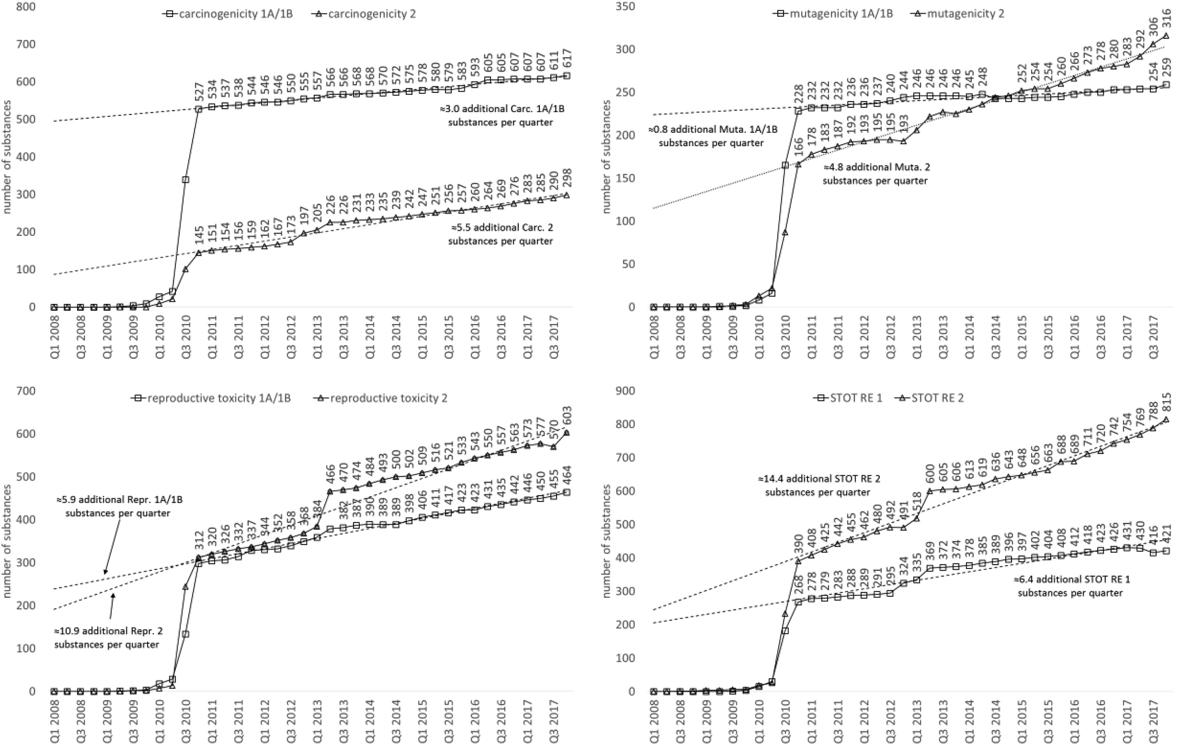

In [7]:
# The figure below is from https://doi.org/10.1016/j.yrtph.2019.05.003 cited above
from PIL import Image
import requests
url = 'https://ars.els-cdn.com/content/image/1-s2.0-S0273230019301254-gr3_lrg.jpg'
im = Image.open(requests.get(url, stream=True).raw)
new_width = int(im.width / 3)
new_height = int(im.height / 3)
im_resized = im.resize((new_width, new_height))
display(im_resized)

In [8]:
# load the dataset into a Pandas dataframe
gentox_data = pd.read_excel('genotoxicity_dataset.xlsx')
gentox_data.head(n=5) # display the first 5 rows


,datapoint ID,smiles_std,genotoxicity,endpoint
0,0,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 100), no"
1,1,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 100), yes"
2,2,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 1535), no"
3,3,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 1535), yes"
4,4,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 1537), no"


In [9]:
gentox_data.tail(n=5) # display the last 5 rows

,datapoint ID,smiles_std,genotoxicity,endpoint
53876,53876,n1n[nH]c(-c2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 1537), yes"
53877,53877,n1n[nH]c(-c2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), no"
53878,53878,n1n[nH]c(-c2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), yes"
53879,53879,n1n[nH]c(Nc2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), no"
53880,53880,n1n[nH]c(Nc2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), yes"


#### Data types
The different columns can be of different types, such as floats, integers, strings, datetime, objects or other.

In [10]:
gentox_data.dtypes

,0
datapoint ID,int64
smiles_std,object
genotoxicity,object
endpoint,object


The dataset only contains 4 columns, a datapoint ID, the structure as a smiles string, the genotoxicity outcome as a string and the endpoint, which in our case is simply the bacterial strain and metabolic activation status. Hence, there is no need to drop any column as all of them are relevant for our modelling.

Although we could use the smiles as a structure ID it may be more convenient to generate one more column with the molecule ID being an integer. For each unique smiles we will assign a different molecule ID.

In [11]:
# create a molecule ID column
codes, uniques = pd.factorize(gentox_data['smiles_std'])
gentox_data.insert(loc=1, column='molecule ID', value=codes)
gentox_data

,datapoint ID,molecule ID,smiles_std,genotoxicity,endpoint
0,0,0,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 100), no"
1,1,0,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 100), yes"
2,2,0,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 1535), no"
3,3,0,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 1535), yes"
4,4,0,B12B3B4B1C234,negative,"Salmonella typhimurium (TA 1537), no"
...,...,...,...,...,...
53876,53876,7327,n1n[nH]c(-c2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 1537), yes"
53877,53877,7327,n1n[nH]c(-c2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), no"
53878,53878,7327,n1n[nH]c(-c2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), yes"
53879,53879,7328,n1n[nH]c(Nc2nnn[nH]2)n1,negative,"Salmonella typhimurium (TA 98), no"


Nice! Now we can refer to the molecule ID column when we want to locate a given molecular structure and the datapoint ID when we want to locate a given experimental measurement. Next we will examine if there are any rows with null values. Pandas offers a convenience function for this purpose.

In [12]:
gentox_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53881 entries, 0 to 53880
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datapoint ID  53881 non-null  int64 
 1   molecule ID   53881 non-null  int64 
 2   smiles_std    53881 non-null  object
 3   genotoxicity  53881 non-null  object
 4   endpoint      53881 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.1+ MB


The dataset contains 53881 rows and there are no missing values in any of the four columns. In real life applications a dataset is rarely so tidy. This dataset has been extensively curated for the purposes of this training.

#### Counts and duplicates

Before we continue we can investigate how many structures we have, the number and type of strains and whether we have data for all strains for each and every structure.

In [13]:
# available strains and metabolic activations
gentox_data['endpoint'].drop_duplicates().sort_values(ascending=True)

,endpoint
27,"Escherichia coli (WP2 Uvr A), no"
28,"Escherichia coli (WP2 Uvr A), yes"
0,"Salmonella typhimurium (TA 100), no"
1,"Salmonella typhimurium (TA 100), yes"
2,"Salmonella typhimurium (TA 1535), no"
3,"Salmonella typhimurium (TA 1535), yes"
4,"Salmonella typhimurium (TA 1537), no"
5,"Salmonella typhimurium (TA 1537), yes"
6,"Salmonella typhimurium (TA 98), no"
7,"Salmonella typhimurium (TA 98), yes"


We have data for five strains, each with and without metabolic activation. Some of the strains may be detecting the same genotoxicity mode of action. Some of these strains may also be more predictive of gene mutation than others. Any feedback from mutagenicity experts participating in the training?

Next, we can count the number of structures and the data availability for each.

In [14]:
# number of structures
n_structures = gentox_data['smiles_std'].nunique()
print(f'There are {n_structures} unique structures in the dataset.')

There are 7329 unique structures in the dataset.


It will be very confusing if there are multiple genotoxicity outcomes for same structure and endpoint. This will confuse the models and the evaluation of their predictive performance. We can check this before we continue.

In [15]:
gentox_data[['molecule ID', 'endpoint', 'genotoxicity']].duplicated().sum()

0

#### Data availability

There are no duplicates, which means that there is no more than one genotoxicity outcome for each molecular structure and endpoing. This does not mean that we have data for the same endpoint for each structure. Lets examine this next by counting the number of endpoints per molecular structure.

In [16]:
# data availability
gentox_data.groupby('molecule ID')['endpoint'].count()

,endpoint
molecule ID,
0,8
1,5
2,6
3,8
4,10
...,...
7324,10
7325,8
7326,10


We can see that some molecular structures have data for all ten strain/metabolic activation combinations, whilst others are not so data rich. It will be interesting to visualise the data density for the whole dataset.

We can achieve this by counting the unique values of the previous count using method chaining.

In [17]:
tmp = (gentox_data.groupby('molecule ID')['endpoint']
 .count().rename('number of endpoints')
 .value_counts().rename('number of structures')
 .sort_index(ascending=False))
tmp

,number of structures
number of endpoints,
10,2703
9,23
8,2575
7,50
6,225
5,74
4,447
3,186
2,582


Perhaps it is easier to appreciate the data density by creating a barplot.

<Axes: xlabel='number of endpoints', ylabel='number of structures'>

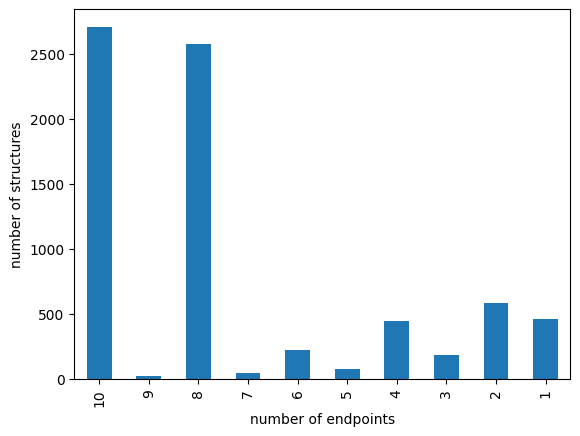

In [18]:
tmp.plot(kind='bar', ylabel='number of structures', xlabel='number of endpoints')

We can see that from the 7329 structures, approximate 2500 have data for all ten strain and metabolic activation combinations. Approximately the same number of structures have data for 8 combinations. The remaining 1/3 of the structures are less data rich.

We can also visualise the data density for each strain and metabolic activation.

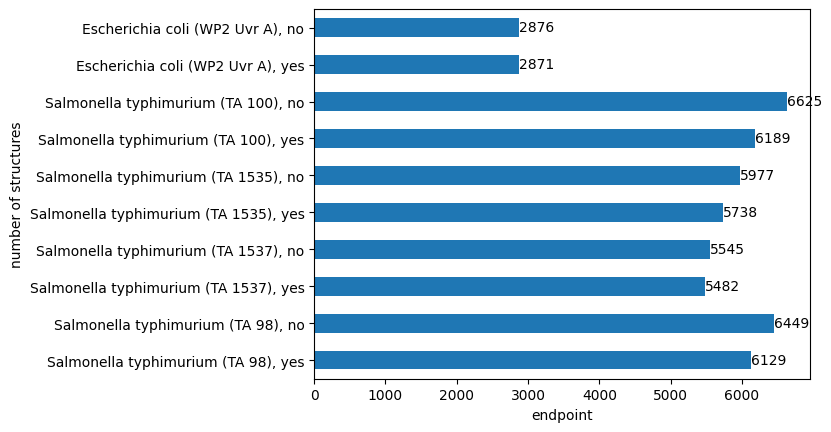

In [19]:
tmp = (gentox_data.groupby('endpoint')['molecule ID']
 .count().rename('number of structures')
 .sort_index(ascending=False))
ax = tmp.plot(kind='barh', ylabel='number of structures', xlabel='endpoint')
for p in ax.patches:
    ax.text(p.get_width(), p.get_y() + p.get_height()/2., '%d' % int(p.get_width()),
            ha='left', va='center')

The most data rich strains are TA 100 and 98. This is good news, as these strains are quite predictive for the overall Ames genotoxicity outcome.

Before we proceed with the inspection of the molecular structures and the generation of fingerprints we can examine how often we have data for endpoint pairs. We will be using a function because we will need to do this calculation more than once!

In [20]:
def create_endpoint_pair_data(df):
  endpoint_pair_data = []
  for endpoint1 in gentox_data['endpoint'].unique():
    msk1 = gentox_data['endpoint'] == endpoint1
    for endpoint2 in gentox_data['endpoint'].unique():
      msk2 = gentox_data['endpoint'] == endpoint2
      tmp = gentox_data.loc[msk1 | msk2].pivot(index='molecule ID', columns='endpoint', values='genotoxicity')
      tmp = tmp.dropna(how='any')
      endpoint_pair_data.append({'endpoint 1': endpoint1, 'endpoint 2': endpoint2, 'support': len(tmp)})
  endpoint_pair_data = pd.DataFrame(endpoint_pair_data)
  endpoint_pair_data = endpoint_pair_data.pivot(index='endpoint 1', columns='endpoint 2', values='support')
  return endpoint_pair_data
endpoint_pair_data = create_endpoint_pair_data(gentox_data)
endpoint_pair_data

endpoint 2,"Escherichia coli (WP2 Uvr A), no","Escherichia coli (WP2 Uvr A), yes","Salmonella typhimurium (TA 100), no","Salmonella typhimurium (TA 100), yes","Salmonella typhimurium (TA 1535), no","Salmonella typhimurium (TA 1535), yes","Salmonella typhimurium (TA 1537), no","Salmonella typhimurium (TA 1537), yes","Salmonella typhimurium (TA 98), no","Salmonella typhimurium (TA 98), yes"
endpoint 1,,,,,,,,,,
"Escherichia coli (WP2 Uvr A), no",2876,2861,2770,2766,2762,2756,2744,2739,2766,2759
"Escherichia coli (WP2 Uvr A), yes",2861,2871,2762,2766,2756,2755,2737,2740,2757,2759
"Salmonella typhimurium (TA 100), no",2770,2762,6625,5980,5797,5569,5439,5380,6283,5889
"Salmonella typhimurium (TA 100), yes",2766,2766,5980,6189,5578,5614,5367,5418,5877,5955
"Salmonella typhimurium (TA 1535), no",2762,2756,5797,5578,5977,5638,5458,5381,5718,5528
"Salmonella typhimurium (TA 1535), yes",2756,2755,5569,5614,5638,5738,5362,5422,5520,5561
"Salmonella typhimurium (TA 1537), no",2744,2737,5439,5367,5458,5362,5545,5393,5411,5336
"Salmonella typhimurium (TA 1537), yes",2739,2740,5380,5418,5381,5422,5393,5482,5348,5394
"Salmonella typhimurium (TA 98), no",2766,2757,6283,5877,5718,5520,5411,5348,6449,5979


We will now visualise the created `enpoint_pair_data` dataframe using a heatmap. Once more we will be using a function for this because we will need thid functionality later on.

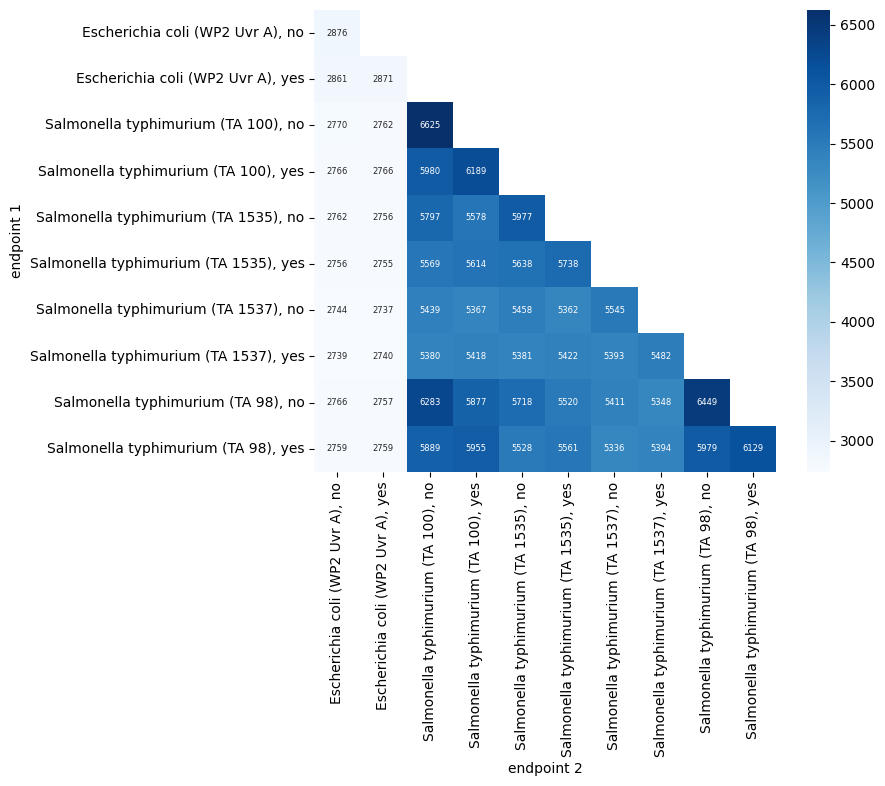

In [21]:
# visualise the simultaneous data availability for two endpoints using a heatmap
def create_heatmap(endpoint_pair_data):
  mask = np.triu(np.ones_like(endpoint_pair_data, dtype=bool), k=1)
  fig = plt.figure(figsize=(8, 6))
  ax = fig.subplots()
  sns.heatmap(endpoint_pair_data, annot=True, mask=mask, fmt='d', cmap='Blues', square=True, ax=ax, annot_kws={"fontsize": 6} )
create_heatmap(endpoint_pair_data)

The diagonal in the heatmap provides the data availability for a single endpoint and the numbers must agree with the numbers we show earlier in the barplot.

Before we conclude this section there is an important decision to take. The genotoxicity outcomes in the dataset are positive, negative and ambiguous, with the latter including both equivocal and otherwise compromised measurements (e.g. due to inappropriate cytoxicity or occurrence of precipitation).

In [22]:
gentox_data['genotoxicity'].value_counts()

,count
genotoxicity,
negative,46993
positive,6515
ambiguous,373


The number of ambiguous calls is quite small. Hence it is best to exclude them. This means that the number of labels will be reduced to two and hence the classification models will become binary rather than multiclass.

In [23]:
# exclude ambiguous genotoxicity calls
msk = gentox_data['genotoxicity'] != 'ambiguous'
gentox_data = gentox_data[msk]
gentox_data['genotoxicity'].value_counts()

,count
genotoxicity,
negative,46993
positive,6515


Lets' create the heatmap once more to visualise the reduction in terms of number of structures for each endpoint combination.

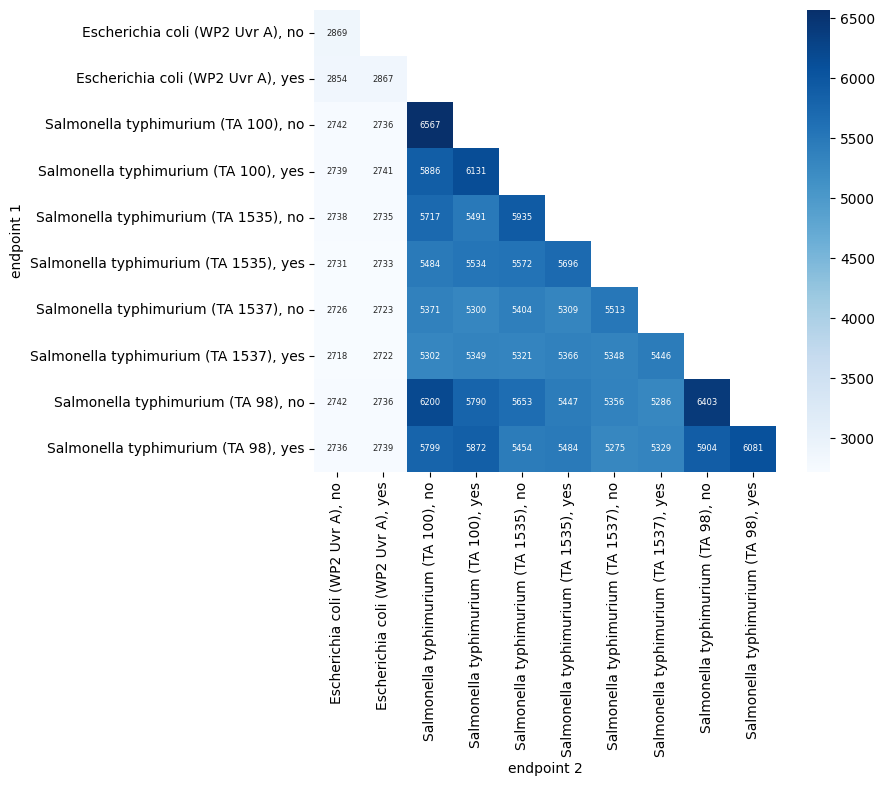

In [24]:
endpoint_pair_data = create_endpoint_pair_data(gentox_data)
create_heatmap(endpoint_pair_data)

The dataset has not been reduced significantly in size. The number of structures is sufficient to attempt fitting a model.

## Structure visualisation and feature generation

Following the dataset preparation and exploration, the next decision we need to take is what kind of features we can use for representing the molecular structures. There are many options, including descriptors like Padel, molecular fingerprints and graph like molecular representations. For the purposes of this training course we will be using Morgan fingerprints generated using rdkit.

Lets' create a function to visualise a molecular structure and the available experimental data, and use it for a could of molecular structures in our dataset.

### Molecular structure visualisation

In [25]:
def visualise_molecule(molecule_id, annotate=False):
  '''
  Visualise a molecular structure and the available experimental data
  molecule_id: the molecule ID to visualise
  annotate: if False (default) it will annotate the molecule with the available experimental data. If explicitly set to a string it
  will annotate the molecule using the provided text (useful for when we generate the predictions later on)
  '''
  # select the relevant portion of the dataset
  msk = gentox_data['molecule ID'] == molecule_id
  smiles = gentox_data.loc[msk, 'smiles_std'].iloc[0]
  mol = Chem.MolFromSmiles(smiles)
  # draw the molecule
  img = Draw.MolToImage(mol)
  fig = plt.figure(figsize=(4, 4))
  ax = fig.subplots()
  ax.imshow(img)
  ax.axis('off')
  if not annotate:
    genotoxity_outcome = gentox_data.loc[msk, ['endpoint', 'genotoxicity']].set_index('endpoint').squeeze().to_dict()
    genotoxity_outcome = '\n'.join([f'{k:40s}: {v}' for k, v in genotoxity_outcome.items()])
    genotoxity_outcome
    annotation_text = genotoxity_outcome
  else:
    annotation_text = annotate
  ax.text(2, 300, annotation_text, fontdict={'family': 'monospace', 'size': 8, 'color': 'k'}, verticalalignment='top')  # Annotate
  fig.tight_layout()

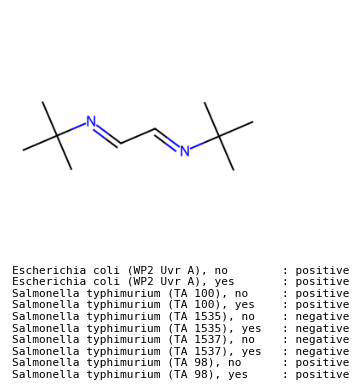

In [26]:
molecule_id = 1000
visualise_molecule(molecule_id)

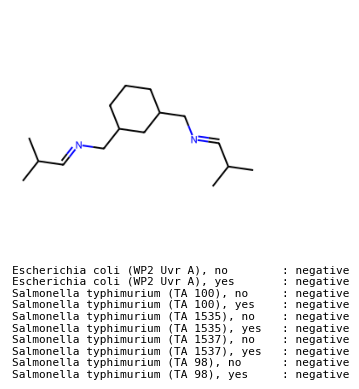

In [27]:
molecule_id = 1200
visualise_molecule(molecule_id)

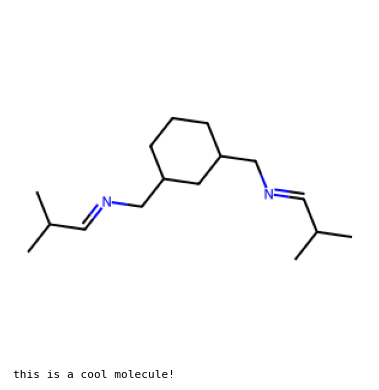

In [28]:
molecule_id = 1200
visualise_molecule(molecule_id, 'this is a cool molecule!')

Lets' create an interactive slider to allow the visualisation of a grid with molecules. We can change the number of rows and columns of the grid to show more or fewer molecules.

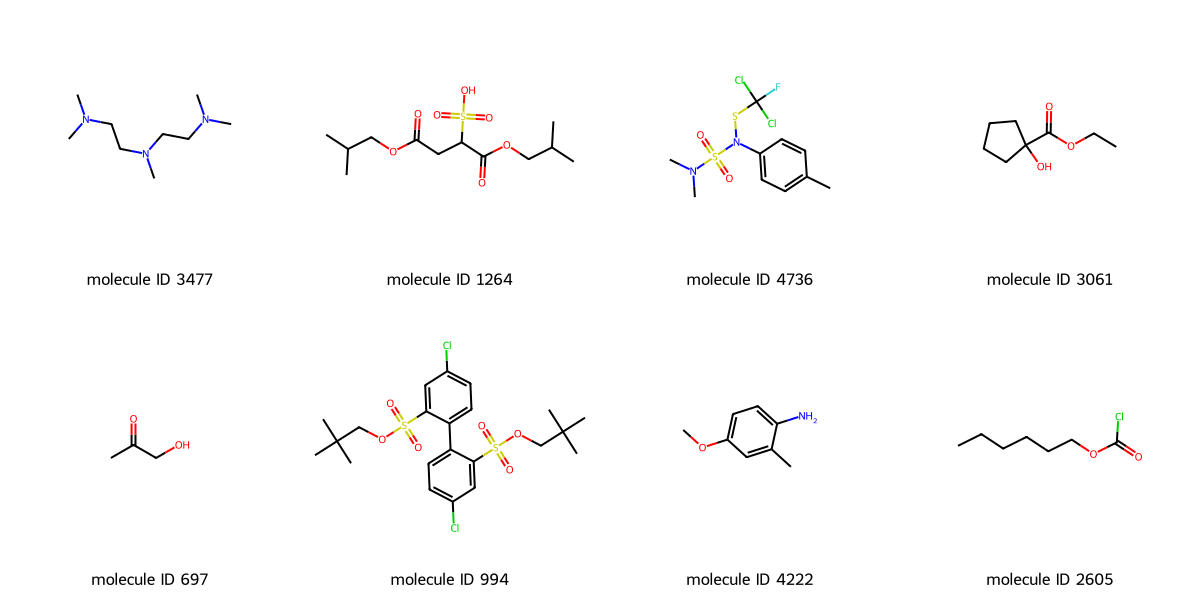

In [30]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import namedtuple

# select how large the grid must be
n_rows = 2
n_cols = 4

# function to generate grid image by randomly drawing molecular structures
def generate_grid(random_state):
  # sample the molecular structures randomly
  tmp = gentox_data[['molecule ID', 'smiles_std']].drop_duplicates().sample(n=n_rows*n_cols, random_state=random_state)
  grid_image = Draw.MolsToGridImage(
      [Chem.MolFromSmiles(smiles) for smiles in tmp['smiles_std']],
      molsPerRow=n_cols,
      subImgSize=(300, 300),  # size of each molecule image
      legends=[f"molecule ID {molecule_id}" for molecule_id in tmp['molecule ID']]  # add legends
  )
  return grid_image

# create a slider widget for going back and forth in the visualization
slider = widgets.IntSlider(
  value=0,  # start at the first set of molecules
  min=0,  # minimum value (first set of molecules)
  max=9,  # maximum value (last set of molecules)
  step=1,
  description='Page:',
  continuous_update=False  # only update on slider release
)
# ceate left and right buttons
left_button = widgets.Button(description="previous")
right_button = widgets.Button(description="next page")
# function to update the slider value when the left button is clicked
def on_left_button_clicked(b):
    if slider.value > slider.min:
        slider.value -= slider.step  # Decrease slider value
# function to update the slider value when the right button is clicked
def on_right_button_clicked(b):
    if slider.value < slider.max:
        slider.value += slider.step  # Increase slider value
# attach the button click events to the respective functions
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# update the image when the slider value changes
def update_image(change):
  # Generate grid image based on the slider value
  grid_image = generate_grid(change.new)
  print(change)
  clear_output(wait=True)
  ui = widgets.HBox([left_button, slider, right_button])
  display(ui)
  display(grid_image)

# attach the update_image function to the slider's value change event
slider.observe(update_image, names='value')

# display the slider and the initial grid image
ui = widgets.HBox([left_button, slider, right_button])
display(ui)
update_image(namedtuple('change', ['new'])(new=0))  # Initial image update



Are the molecular structures amenable to modelling? Do you observe any structure standardisation issues?

### From smiles to RSit molecular structures

Smiles are string representations of the molecular structures that cannot be used for cheminformatics operations, such as substructure searches or fingerprint calculations. In this tutorial we are using the cheminformatics package RDKit and hence we will next convert the smiles to RDKit molecules.

In [31]:
# convert the smiles to rdkit molecules
structures = gentox_data[['molecule ID', 'smiles_std']].drop_duplicates().sort_values('molecule ID', ascending=True)
structures['mol'] = structures['smiles_std'].progress_apply(Chem.MolFromSmiles)
structures = structures.set_index('molecule ID')

  0%|          | 0/7318 [00:00<?, ?it/s]

In [32]:
# ensure that all conversions have been successful
structures['mol'].isna().sum()

0

In [33]:
from rdkit import rdBase
# ensure that there are no structure duplicates, given that two different smiles may encode the same structure
rdBase.DisableLog('rdApp.warning') # suppress RDKit warnings
structures['mol'].progress_apply(lambda mol: Chem.MolToInchi(mol, options='-FixedH')).duplicated().sum()

  0%|          | 0/7318 [00:00<?, ?it/s]

0

Typically one would not expect such lack of failures when converting molecular structure formats and when calculating the InChis. This is because the dataset has been carefullly curated for the purposes of this tutorial.

Before we move on to the fingerprint calculation, lets' compute the molecular weight distribution to have a feeling of molecular structure size and complexity.

  0%|          | 0/7318 [00:00<?, ?it/s]

<Axes: xlabel='molecular weight', ylabel='number of structures'>

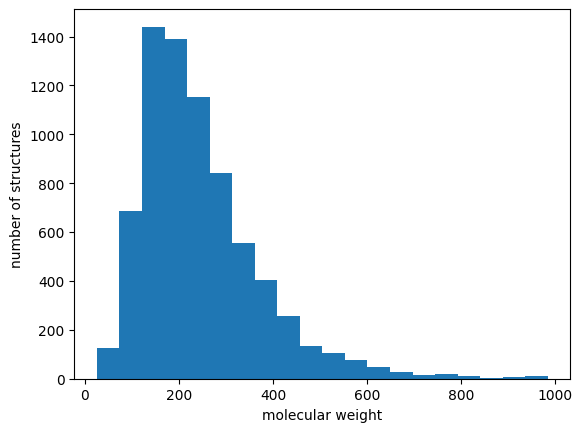

In [34]:
from rdkit.Chem.Descriptors import MolWt
# compute the molecular weight distribution
structures['mol'].progress_apply(MolWt).plot(kind='hist', bins=20, ylabel='number of structures', xlabel='molecular weight')

No molecular structure has molecular weight larger than 1000, which was imposed as a cutoff when the dataset was constructed.

### Fingerprints

In this tutorial we will be using fingerprints for the representation of the molecular structures. There are many variants, but the use of Morgan fingerprints is quite commom. The will be covering the theoretical basis of fingerprints in the lectures. Fingerprints can be of two types, binary and count. The binary fingerprint bits are set to 1 if the corresponding structural moiety is present and 0 if absent, regardless of the number of occurrences in the molecular structure.

Count fingerprints also include the number of occurrences in the molecular structure, without accounting for their relative position. For both binary and count fingerprints we can set the radius and the lengh. The radius reflects the size of he structural moieties assigned to the bits, whilst the length gives the number of bits. There is a tradeoff. If the length is too small bit collisions will be more frequent and detrimental. On the other hand, if the length is too large, the model fitting will take longer and the input vector for each molecule is larger. In addition, most bits will be inactive and it may be harder to train the model even if there is sufficient computing capacity.

We will use binary Morgan fingerprints of radius 2 and of length 1024. In a real life application some more exploration would be needed to optimise the fingerprint parameters, perhaps as part of the hyper parameter tuning that will cover in the second lab.

Lets' calculate the fingerprints next.

In [35]:
# set up the fingerprint calculation
fingerprint_parameters = {'radius': 2,
                          'fpSize': 1024,
                          'type': 'count' # 'binary', 'count'
                          }
# create the fingerprint generator
fpgen = AllChem.GetMorganGenerator(radius=fingerprint_parameters['radius'], fpSize=fingerprint_parameters['fpSize'],
                                   countSimulation=False, includeChirality=False)

In [36]:
# define a help function and compute the binary fingerprints
def compute_fingerprint(mol):
  return fpgen.GetFingerprint(mol).ToList()
structures['fingerprint'] = structures['mol'].progress_apply(compute_fingerprint)

  0%|          | 0/7318 [00:00<?, ?it/s]

In [37]:
# check that all fingerprints are lists of fpSize length
np.alltrue(structures['fingerprint'].apply(lambda x: len(x))==fingerprint_parameters['fpSize'])

True

In [38]:
# convert the fingerprints to a numpy array
X = np.array(structures['fingerprint'].to_list())
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
# check how often are the 1024 fingerprint bits active
pd.qcut(X.sum(axis=0), q=np.linspace(0, 1, 11)).value_counts().to_frame().T

,"(15.999, 38.0]","(38.0, 47.6]","(47.6, 57.9]","(57.9, 70.2]","(70.2, 85.0]","(85.0, 104.0]","(104.0, 132.1]","(132.1, 180.0]","(180.0, 327.4]","(327.4, 4837.0]"
count,110,95,102,103,104,102,101,102,102,103


The way to interpret this is as follows:
- 110 bits are only active in less than 38 structures; these bits correponds to rather infrequent structural moieties
- the most frequenty occuring bit is active in 4837 structures out of the 7318 in the dataset
- there are no bits with zero variance, i.e. they are on or off on all structures; such features would not be suitable for modelling

In [41]:
# check how dense are the fingerprints
pd.qcut(X.sum(axis=1), q=np.linspace(0, 1, 11)).value_counts().to_frame().T

,"(1.999, 12.0]","(12.0, 16.0]","(16.0, 19.0]","(19.0, 21.0]","(21.0, 24.0]","(24.0, 27.0]","(27.0, 30.0]","(30.0, 35.0]","(35.0, 44.0]","(44.0, 86.0]"
count,734,853,809,565,840,801,597,700,722,697


No molecular structure has more than 86 bits active. This is indicative of relatively simple compounds with few functional groups each.

Lets visualise the molecular structure with most bits active.

In [ ]:
print(X.shape)
idx_max = X.sum(axis=1).argmax()
print(idx_max)
print(X.sum(axis=1).max())
print(structures.iloc[idx_max])
visualise_molecule(idx_max, 'this is the most simple structure!')
print(sum(structures.iloc[idx_max],['fingerprint']))
print(structures.iloc[idx_max])
visualise_molecule(idx_max, 'this is the most complex structure!')

In [ ]:
structures.loc[5000]

In [ ]:


# compute the fingerprints
mols = read_sdf(outp_sdf)
data = []
for i_mol, mol in tqdm(enumerate(mols)):
    tox_data = mol.GetProp('genotoxicity')
    tox_data = pd.DataFrame(json.loads(tox_data))
    # keep only positive and negative calls
    tox_data = tox_data.loc[tox_data['genotoxicity'].isin(['positive', 'negative'])]
    if not tox_data.empty:
        fg = fpgen.GetFingerprint(mol)
        fg_count = fpgen.GetCountFingerprint(mol)
        if fingerprint_parameters['type'] == 'binary':
            tox_data['fingerprint'] = ''.join([str(bit) for bit in fg.ToList()]) #fg.ToBitString()
        elif fingerprint_parameters['type'] == 'count':
            tox_data['fingerprint'] = ''.join([str(min(bit, 9)) for bit in fg_count.ToList()])
        else:
            ex = ValueError(f"unknown fingerprint type: {fingerprint_parameters}")
            log.error(ex)
            raise ex
        tox_data['molecule ID'] = i_mol
        data.append(tox_data)
data = pd.concat(data, axis='index', ignore_index=True, sort=False)

# features (fingerprints)
X = data.groupby('molecule ID')['fingerprint'].first()
X = np.array([[float(bit) for bit in list(fg)] for fg in X.to_list()], dtype=np.float32)
# genotoxicity outcomes for each task
task_outcomes = data.pivot(index='molecule ID',columns='task',values='genotoxicity')